![image.png](https://i.imgur.com/a3uAqnb.png)

In [5]:
from IPython.display import clear_output




In [6]:

# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

# %pip install torch
# %pip install torchvision
# %pip install matplotlib

clear_output()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt
import torch.optim as optim

from tqdm import tqdm # Import tqdm function specifically

# Sign Langauge Problem:

## Intution: The AI is so powrful and important because of its various applications on most if not all the different fields. As a result, we want to help in solving the issue of not understanding sign languages.

## - This notebook contains a detailed implementaiton of a NN uisng Pytorch.

### 1. Data set Details:

- The provided data set is ArASL (Arabic Alphabets Sign Language Dataset). It is as its name says, an arabic sighn langauge for Arabic alphabet. It has a total of 54049 images and their corrssponding labels.

### 2. Size of data:
- Length of train_dataset is 43239,
- Length of val_dataset is 10810

### 3. Labels representations:
- Each sample has a label, which can be one of the 32 classes.
It consist of 32 classes for the alphabet.
- The classes values are integers from 0 up to 31.


### 4. The mapping details:

- Each number represents a charcter. You can see the dictionary in the variable "mapping".

<br/>
-- You can see the mapping in the following:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

### 5. Refrence:
Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

## Downloading the dataset

### Run the following cells to download the MNIST dataset.

In [8]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:04<00:00, 14.2MB/s]


In [9]:
import os

def delete_folder(folder_path):
    try:
        # Get the list of files and subdirectories in the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # If it's a file, delete it
            if os.path.isfile(item_path):
                os.remove(item_path)
            # If it's a directory, recursively call delete_folder
            elif os.path.isdir(item_path):
                delete_folder(item_path)

        # Remove the empty folder
        os.rmdir(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_path}' not found.")
    except PermissionError:
        print(f"Permission error: Unable to delete folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


delete_folder('ArASL_Database_54K_Final')

!unzip file_downloaded
clear_output()

## Just run these two cells. You do not need to explore them, but it would be a plus if you understand them.

In [10]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'khaa': 0, 'thal': 1, 'ya': 2, 'thaa': 3, 'dha': 4, 'bb': 5, 'saad': 6, 'dhad': 7, 'ra': 8, 'dal': 9, 'meem': 10, 'fa': 11, 'haa': 12, 'taa': 13, 'kaaf': 14, 'ta': 15, 'al': 16, 'gaaf': 17, 'nun': 18, 'toot': 19, 'sheen': 20, 'aleff': 21, 'ghain': 22, 'ha': 23, 'seen': 24, 'zay': 25, 'jeem': 26, 'waw': 27, 'ain': 28, 'laam': 29, 'yaa': 30, 'la': 31}


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(48, 48)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([
    # transforms.Resize((48, 48)),
    transforms.ToTensor(),

])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [12]:
train_dataset # Contains the training ArASL_Database_54K_Final dataset (80%)

val_dataset  # Contains the validating ArASL_Database_54K_Final dataset (20%)


print("The mapping between the letters and the encoding: \n", mapping)

# Check the lengths of train_dataset and val_dataset.
print(f'length of train is {len(train_dataset)}')
print(f'length of train is {len(val_dataset)}')

The mapping between the letters and the encoding: 
 {0: 'khaa', 1: 'thal', 2: 'ya', 3: 'thaa', 4: 'dha', 5: 'bb', 6: 'saad', 7: 'dhad', 8: 'ra', 9: 'dal', 10: 'meem', 11: 'fa', 12: 'haa', 13: 'taa', 14: 'kaaf', 15: 'ta', 16: 'al', 17: 'gaaf', 18: 'nun', 19: 'toot', 20: 'sheen', 21: 'aleff', 22: 'ghain', 23: 'ha', 24: 'seen', 25: 'zay', 26: 'jeem', 27: 'waw', 28: 'ain', 29: 'laam', 30: 'yaa', 31: 'la'}
length of train is 43239
length of train is 10810


In [13]:
train_dataset[0][0].shape

torch.Size([1, 48, 48])

In [14]:
batch_size = 64 # To group each k samples together.

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize an image.

The image label: 1 thal


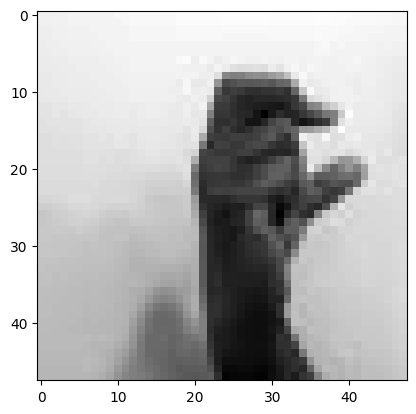

The image label: 6 saad


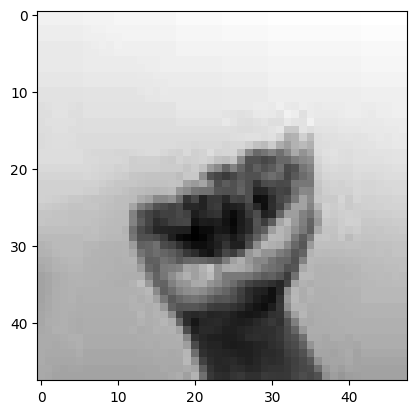

The image label: 15 ta


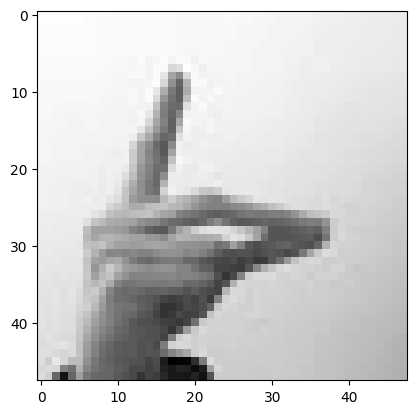

The image label: 4 dha


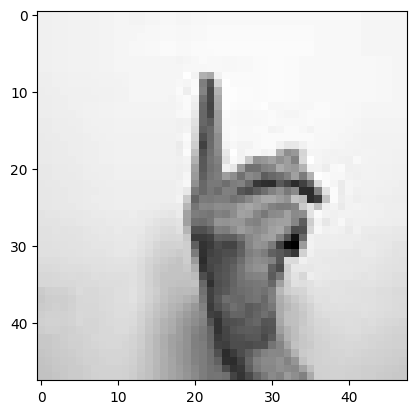

The image label: 18 nun


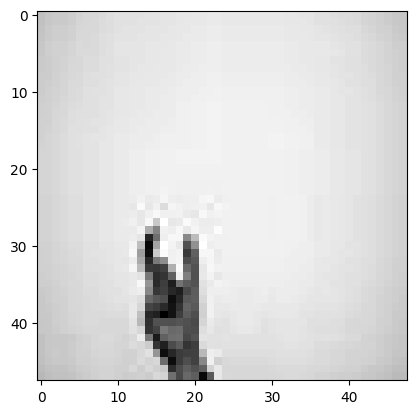

The image label: 7 dhad


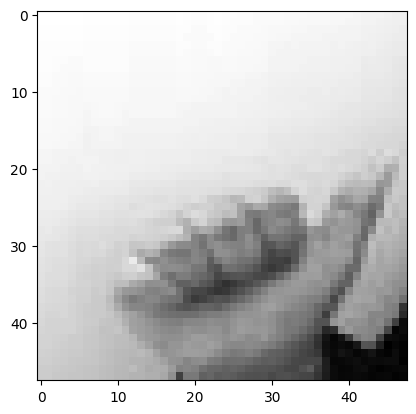

The image label: 12 haa


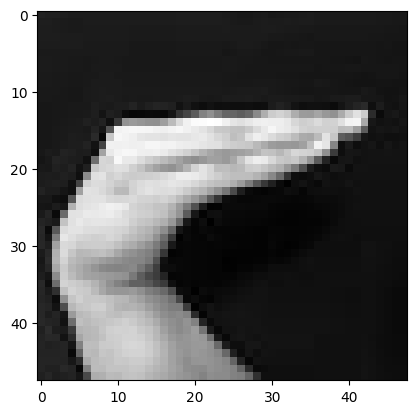

The image label: 22 ghain


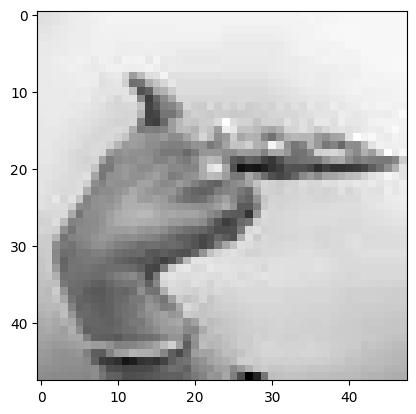

The image label: 10 meem


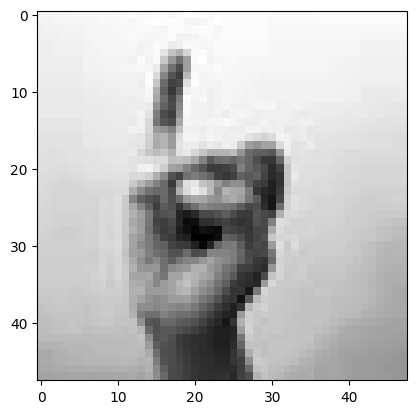

The image label: 3 thaa


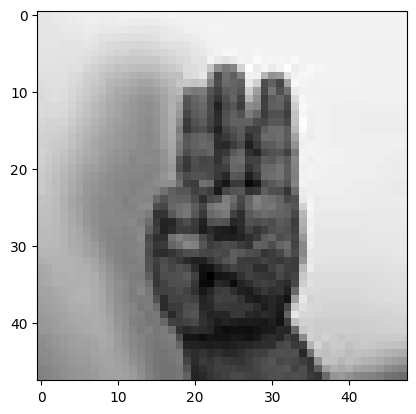

In [15]:
import random
for i in range(10):
  random_img_idx = random.randint(0,len(train_dataset))
  image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
  label = train_dataset[random_img_idx][1]  # 1 for label part
  print("The image label:", label.item(), mapping[label.item()])
  plt.imshow(image.reshape(image.shape[1], image.shape[1]), cmap='gray')
  plt.show()

### Display 10 different images

In [16]:
#done above

### Create a a Varitional Autoencoder model to generate new images.
- Display the loss of the training.
- Show some original images with their reconstructed ones.
- Compare the results with an Autoencoder model.
- Generate new images.

In [17]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Enhanced Encoder with more layers
        self.encoder = nn.Sequential(
            # Input: (1, 48, 48)
            nn.Conv2d(1, 32, 4, 2, 1),      # (32, 24, 24)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 32, 3, 1, 1),     # (32, 24, 24) - Additional layer for more robust learning
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 4, 2, 1),     # (64, 12, 12)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, 3, 1, 1),     # (64, 12, 12) - Additional layer
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),    # (128, 6, 6)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, 3, 1, 1),   # (128, 6, 6) - Additional layer
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),   # (256, 3, 3)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, 3, 1, 1),   # (256, 3, 3) - Additional layer
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),


            nn.Flatten(),                   # (512 * 3 * 3)
        )

        # Enhanced latent space mapping with intermediate layer
        self.fc_intermediate = nn.Sequential(
            nn.Linear(256 * 3 * 3, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )

        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        # Enhanced Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256 * 3 * 3),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 3, 3)),   # Reshape to (256, 3, 3)

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (256, 6, 6)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 128, 3, 1, 1),  # (256, 6, 6) - Additional layer
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (128, 12, 12)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, 3, 1, 1),  # (128, 12, 12) - Additional layer
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # (64, 24, 24)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 32, 3, 1, 1),    # (64, 24, 24) - Additional layer
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),    # (32, 48, 48)
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, 3, 1, 1),    # (32, 48, 48) - Additional layer
            nn.Sigmoid() # I modified this, sigmoid is always since there were no normalization in the transformation
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.fc_intermediate(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # it creates the stadard normal distribution
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [18]:
# VAE Loss Function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

In [19]:
# Training Loop for VAE
def train_one_epoch(model, dataloader, optimizer, device, beta=1.0):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for images, _ in tqdm(dataloader, desc="Training"):
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = model(images)

        # Compute VAE loss
        loss, recon_loss, kl_loss = vae_loss(recon_images, images, mu, logvar, beta)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_loss = total_kl_loss / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

In [20]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=128).to(device)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 5
beta = 1.0  # Weight for KL divergence

# Store losses for plotting
train_losses = []
recon_losses = []
kl_losses = []

print(f"Training VAE on {device}...")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: {batch_size}")
print("-" * 50)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [21]:
# Training loop
for epoch in range(num_epochs):
    train_loss, recon_loss, kl_loss = train_one_epoch(model, train_loader, optimizer, device, beta)

    train_losses.append(train_loss)
    recon_losses.append(recon_loss)
    kl_losses.append(kl_loss)

    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Total Loss: {train_loss:.4f} | "
          f"Recon: {recon_loss:.4f} | "
          f"KL: {kl_loss:.4f}")

    # Save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'vae_anime_epoch_{epoch+1}.pth')

print("Training completed!")

Training: 100%|██████████| 676/676 [00:30<00:00, 22.02it/s]


Epoch  1/5 | Total Loss: 64.0675 | Recon: 53.3220 | KL: 10.7455


Training: 100%|██████████| 676/676 [00:27<00:00, 24.29it/s]


Epoch  2/5 | Total Loss: 47.4244 | Recon: 37.6172 | KL: 9.8071


Training: 100%|██████████| 676/676 [00:28<00:00, 23.71it/s]


Epoch  3/5 | Total Loss: 43.0197 | Recon: 34.4874 | KL: 8.5323


Training: 100%|██████████| 676/676 [00:28<00:00, 23.69it/s]


Epoch  4/5 | Total Loss: 40.7470 | Recon: 32.4930 | KL: 8.2540


Training: 100%|██████████| 676/676 [00:27<00:00, 24.14it/s]

Epoch  5/5 | Total Loss: 38.9524 | Recon: 30.7183 | KL: 8.2341
Training completed!


# Contributed by: Hassan Alsayhah

![image.png](https://i.imgur.com/a3uAqnb.png)

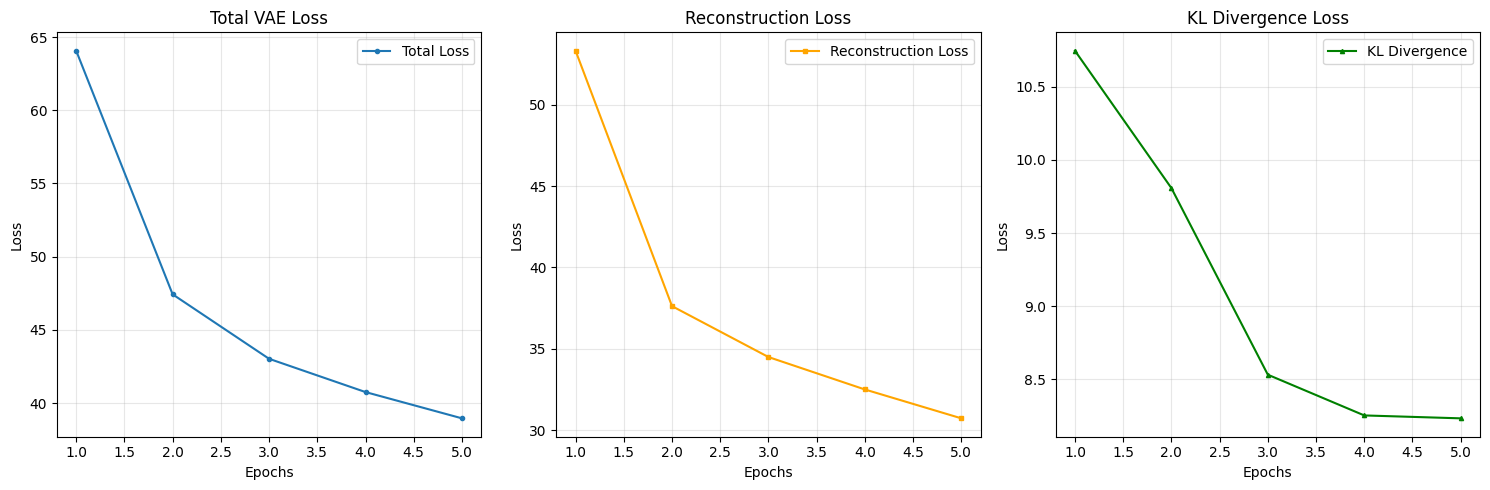

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Total Loss", marker='o', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total VAE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), recon_losses, label="Reconstruction Loss", color='orange', marker='s', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Reconstruction Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), kl_losses, label="KL Divergence", color='green', marker='^', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("KL Divergence Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

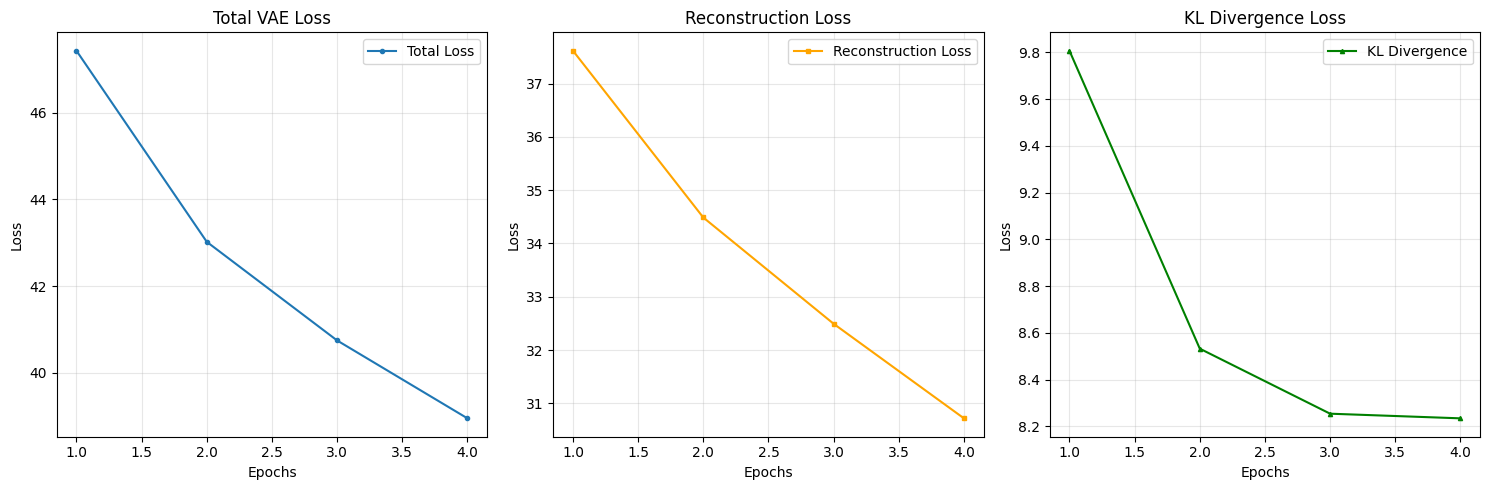

In [23]:
# Plot loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs), train_losses[1:], label="Total Loss", marker='o', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total VAE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs), recon_losses[1:], label="Reconstruction Loss", color='orange', marker='s', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Reconstruction Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs), kl_losses[1:], label="KL Divergence", color='green', marker='^', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("KL Divergence Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

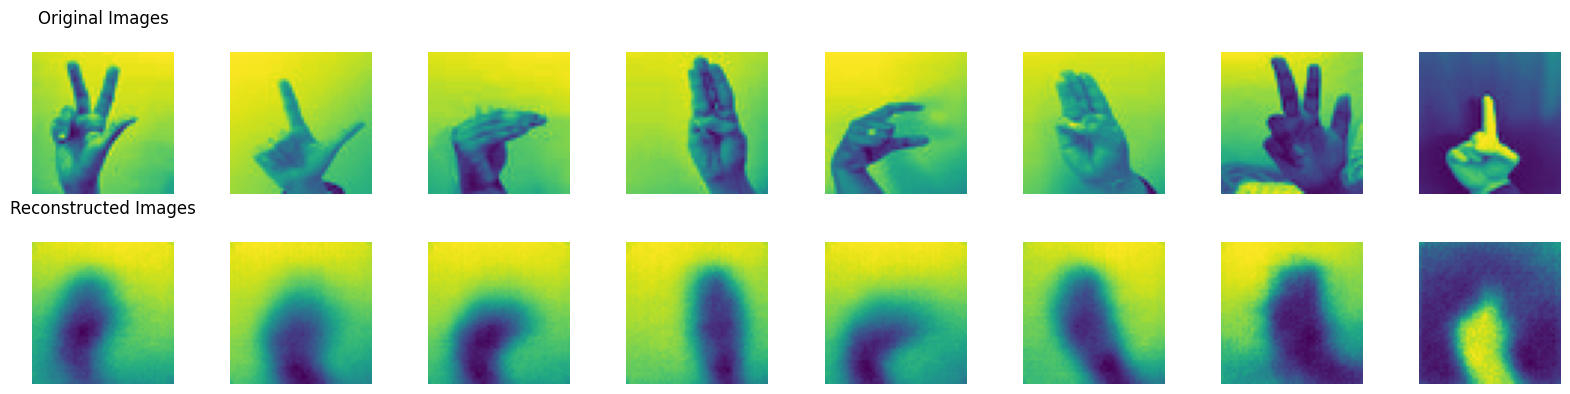

In [24]:
# Function to Display Original vs. Reconstructed Images
def show_original_vs_reconstructed(model, dataloader, device, num_images=8):
    model.eval()

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)

    # Get reconstructed images
    with torch.no_grad():
        reconstructions, _, _ = model(images)

    # Move to CPU and denormalize
    images = images.cpu()
    reconstructions = reconstructions.cpu()

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images (Top row)
        img_orig = torch.clamp(images[i].permute(1, 2, 0), 0, 1)
        axes[0, i].imshow(img_orig.numpy())
        axes[0, i].axis("off")

        # Reconstructed images (Bottom row)
        img_recon = torch.clamp(reconstructions[i].permute(1, 2, 0), 0, 1)
        axes[1, i].imshow(img_recon.numpy())
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12, pad=20)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12, pad=20)
    plt.tight_layout()
    plt.show()

# Display Results
show_original_vs_reconstructed(model, train_loader, device)

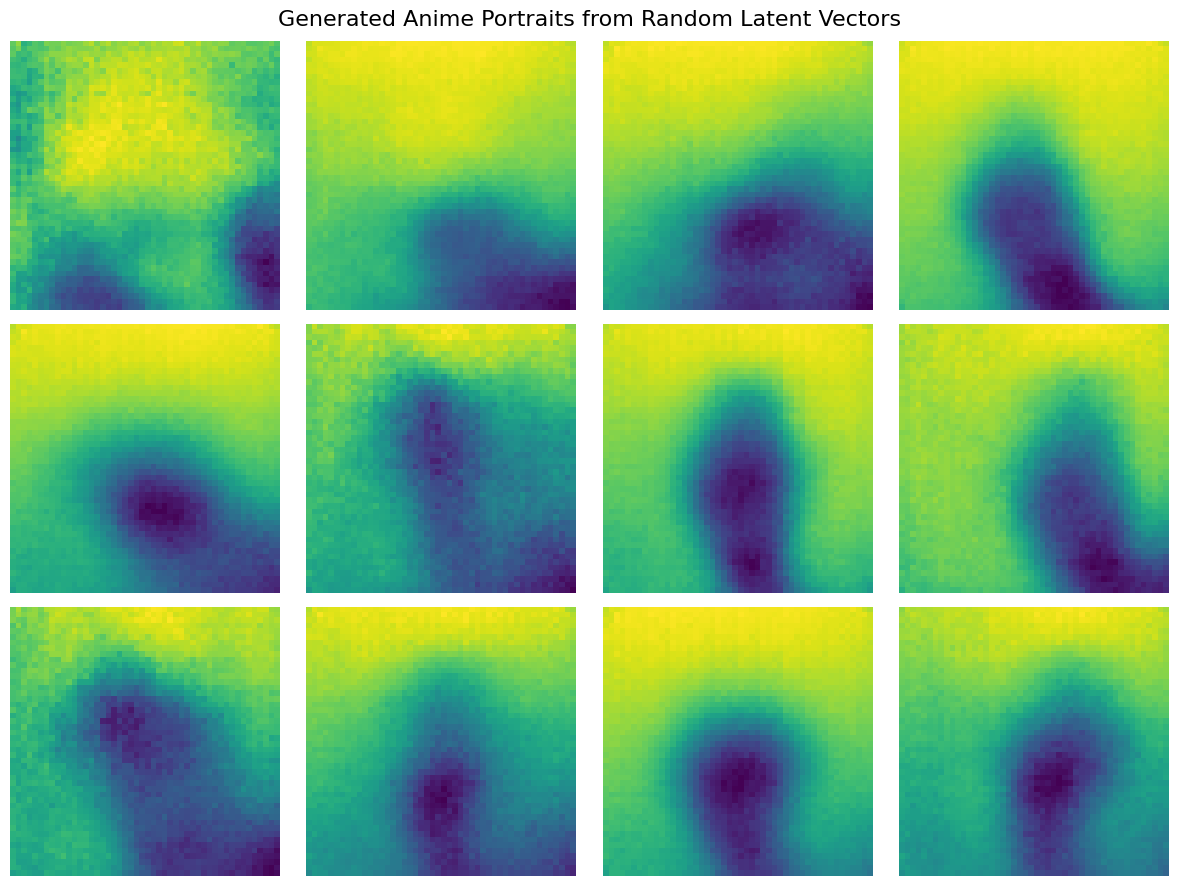

In [25]:
import matplotlib.pyplot as plt

# Function to Generate New Images
def generate_images(model, device, num_images=12, latent_dim=128):
    model.eval()

    # Sample from standard normal distribution
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decode(z).cpu()
    generated_images = torch.clamp(generated_images, 0, 1)

    # Plot generated images
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axes.flat):
        img = generated_images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle("Generated Anime Portraits from Random Latent Vectors", fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate & Display New Anime Images
generate_images(model, device, num_images=12, latent_dim=128)